In [2]:
library(Seurat)
library(dplyr)
library(Matrix)
library(patchwork)
library(ggplot2)

NMdata<-readRDS(file="/home/liusong/scRNA/endometriosis/V2data/RNA_Seq/NM_data/GSE111976_ct_endo_10x.rds") #data downloaded from GEO
 
#remove ribosome gene
rb.genes<-rownames(NMdata)[grep("^RP[SL]",rownames(NMdata))]
rawdata<-NMdata[!(rownames(NMdata) %in% rb.genes),]

NMData <- CreateSeuratObject(count = rawdata)
NMData

An object of class Seurat 
33434 features across 71032 samples within 1 assay 
Active assay: RNA (33434 features, 0 variable features)
 1 layer present: counts

,orig.ident,nCount_RNA,nFeature_RNA,day,donor,cell_type,phase_canonical,percent.mt
,<fct>,<dbl>,<int>,<int>,<int>,<chr>,<fct>,<dbl>
14_AAACCCAAGTAATACG,14,8356,2967,17,14,Stromal fibroblasts,secretory_early,5.732408
14_AAACCCAGTCCTTAAG,14,3908,1828,17,14,Stromal fibroblasts,secretory_early,2.354145
14_AAACGAAAGGCGATAC,14,17770,4765,17,14,Unciliated epithelia 1,secretory_early,10.151941
14_AAACGCTAGACTGTTC,14,12015,3810,17,14,Unciliated epithelia 1,secretory_early,9.121931
14_AAACGCTAGAGTGTTA,14,46834,6357,17,14,Unciliated epithelia 1,secretory_early,5.963616
14_AAACGCTAGTCTAGCT,14,41478,6833,17,14,Unciliated epithelia 1,secretory_early,10.347654


donor,phase_canonical
<int>,<chr>
14,secretory_early
19,proliferative
20,secretory_mid
29,secretory_early-mid
39,secretory_early-mid
41,secretory_early-mid
57,secretory_late
58,secretory_early
60,secretory_early


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Normalizing layer: counts

Finding variable features for layer counts

Regressing out nCount_RNA, percent.mt

Centering and scaling data matrix

Warning message:
"The following features are not present in the object: SEPP1, not searching for symbol synonyms"


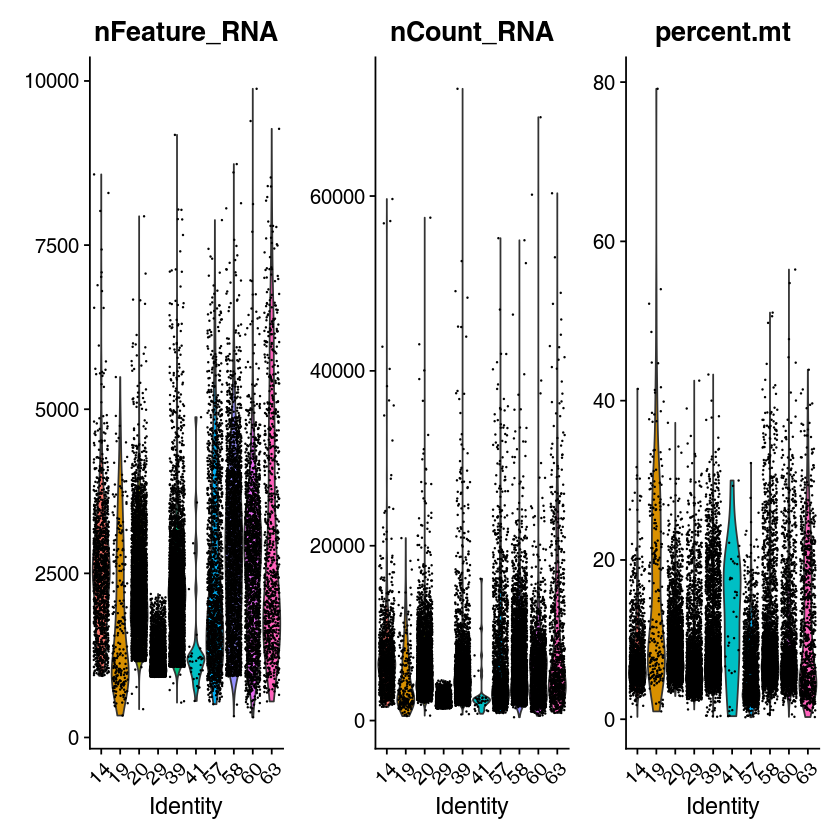

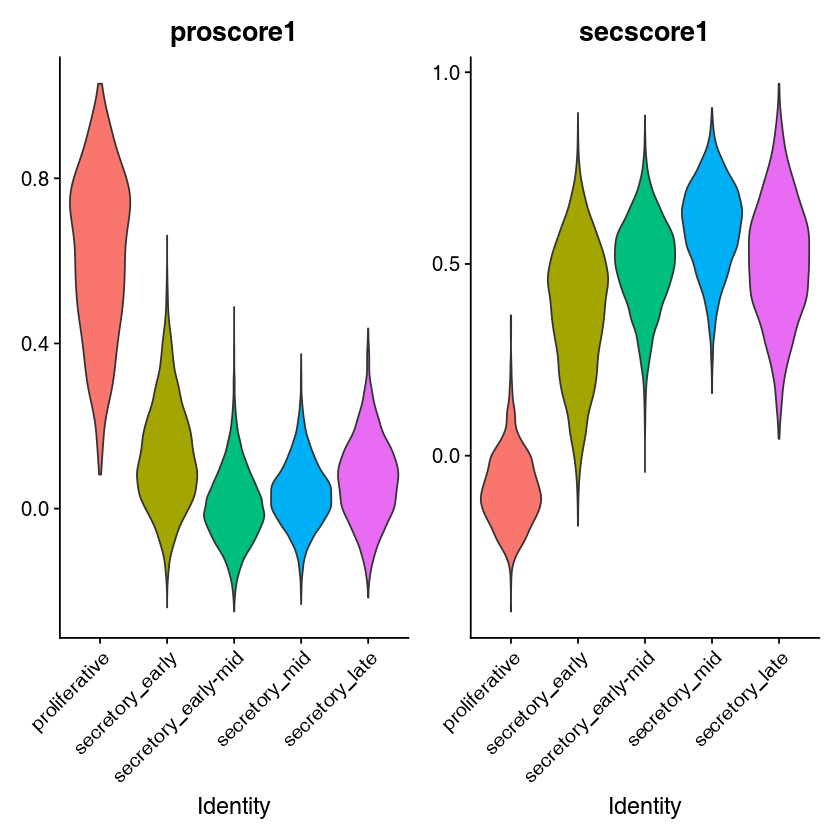

In [6]:
metadata<-read.csv("/home/liusong/scRNA/endometriosis/V2data/RNA_Seq/NM_data/GSE111976_summary_10x_day_donor_ctype.csv")
NMData@meta.data$day<-metadata$day
NMData@meta.data$donor<-metadata$donor
NMData@meta.data$cell_type<-metadata$cell_type
head(NMData@meta.data)
menstrual<-read.csv(file="/home/liusong/scRNA/endometriosis/V2data/RNA_Seq/NM_data/GSE111976_summary_10x_donor_phase.csv")
menstrual
NMData@meta.data$phase_canonical<-factor(NMData@meta.data$donor,levels=menstrual$donor,labels=menstrual$phase_canonical)
NMData[["percent.mt"]] <- PercentageFeatureSet(NMData, pattern = "^MT-")

NMstromal<-subset(NMData,cell_type=="Stromal fibroblasts")
VlnPlot(NMstromal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
NMstromal <- subset(NMstromal, subset =  nFeature_RNA < 7500 & nCount_RNA< 50000 & percent.mt < 20)
NMstromal <- NormalizeData(object = NMstromal, normalization.method = "LogNormalize", scale.factor = 10000)
NMstromal <- FindVariableFeatures(object = NMstromal,selection.method = "vst", nfeatures = 1000)
NMstromal <- ScaleData(NMstromal,vars.to.regress = c("nCount_RNA", "percent.mt"))

#read menstrual feature genes
Menstrual.genes<-read.csv(file="/home/liusong/scRNA/endometriosis/V2data/scanpy/21samples/R_reanalyse/EUstroma/13EU_Menstrual_makers_FC1.csv")
progene<-list(Menstrual.genes$gene[Menstrual.genes$cluster=="PEU"])
secgene<-list(Menstrual.genes$gene[Menstrual.genes$cluster=="SEU"])
NMstromal <-AddModuleScore(NMstromal,features=progene,ctrl=100,name="proscore")
NMstromal <-AddModuleScore(NMstromal,features=secgene,ctrl=100,name="secscore")
Idents(NMstromal)<-"phase_canonical"
levels(NMstromal)<-c("proliferative","secretory_early","secretory_early-mid","secretory_mid","secretory_late")
VlnPlot(NMstromal,features=c("proscore1","secscore1"),pt.size=0)

#saveRDS(NMstromal,file="NM_stromal_Menstrual_validation.rds")


Warning message:
"Removing 5750 cells missing data for vars requested"


An object of class Seurat 
68578 features across 66304 samples within 2 assays 
Active assay: SCT (30354 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: harmony, pca, umap

Warning message:
"The following features are not present in the object: SEPP1, not searching for symbol synonyms"


$Endometrioma_Follicular
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.13569  0.07199  0.11961  0.13896  0.20928  0.46713 

$Endometrioma_Luteal
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.30880 -0.04350  0.02295  0.02693  0.09700  0.31136 

$Endometriosis_Follicular
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.18272  0.06671  0.16085  0.16670  0.25848  0.67256 

$Endometriosis_Luteal
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.339081 -0.127624 -0.066005 -0.002316  0.014209  0.871738 

$`Eutopic Endometrium_Follicular`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.25961  0.08013  0.16152  0.16448  0.24693  0.66315 

$`Eutopic Endometrium_Luteal`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.37099 -0.14338 -0.08247  0.00221  0.04521  0.85947 


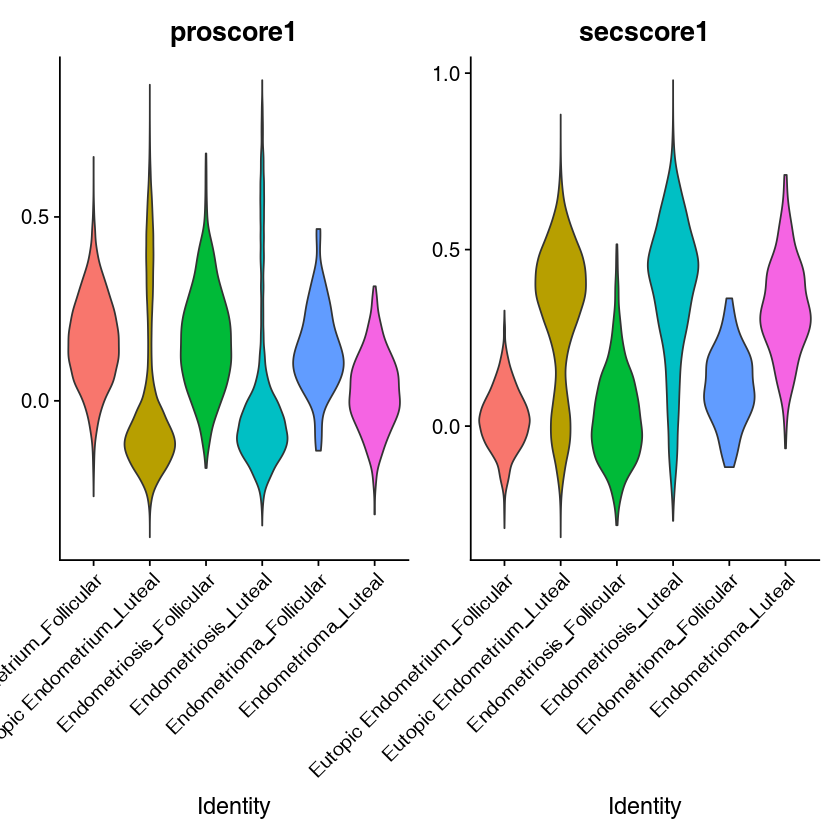

In [10]:
#for the NGdata
NGdata<-readRDS(file="/home/liusong/scRNA/endometriosis/V3data/Downloaded_scRNA_data/NG_EMS/aux.seurat.shared.rds")
NGEnS<-read.csv(file="/home/liusong/scRNA/endometriosis/V3data/Downloaded_scRNA_data/NG_EMS/EU_OMA_PEM_allstroma/obs.csv")

NGstromal<-subset(NGdata,cells=as.character(NGEnS$X))
NGstromal@meta.data$mygroup<-paste0(NGstromal@meta.data$Major.Class,"_",NGstromal@meta.data$Menstrual.Cycle)
NGstromal<-subset(NGstromal,Menstrual.Cycle %in% c("Follicular","Luteal"))
NGstromal
DefaultAssay(NGstromal) <- "RNA"

NGstromal<-AddModuleScore(NGstromal,features=progene,ctrl=100,name="proscore")
NGstromal<-AddModuleScore(NGstromal,features=secgene,ctrl=100,name="secscore")
Idents(NGstromal)<-"mygroup"
levels(NGstromal)<-c("Eutopic Endometrium_Follicular","Eutopic Endometrium_Luteal","Endometriosis_Follicular","Endometriosis_Luteal","Endometrioma_Follicular","Endometrioma_Luteal")
VlnPlot(NGstromal,features=c("proscore1","secscore1"),pt.size=0)

tapply(NGstromal@meta.data$proscore1,NGstromal@meta.data$mygroup,summary)
